In [267]:
#processing
import scikitplot as skplt
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pandas import ExcelWriter
import scipy
scaler = StandardScaler()
label = LabelEncoder()
#sql
import pymysql.cursors 
#NLP
import nltk
import re
import pymorphy2
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#warnings
import warnings
warnings.filterwarnings('ignore')
#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
%matplotlib inline
#vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#model 
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
#classificators
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import datetime
from sklearn.externals import joblib
import IDF
from catboost import CatBoostClassifier

In [268]:
#Подключиться к базе данных
def con():
    conn = pymysql.connect(host='192.168.64.1', port=3306, user='i.serov', password="X3*1Uy(F", db='mysql')
    return conn

In [269]:
%%time
socdem = pd.read_sql('''
    select c.date_requested, 
    datediff(w.next_salary_date, c.date_requested) as days_bef_sal,
        c.id as credit_id,
                      ifnull(IF(c.status IN ('active','completed','expired'),
                      (SELECT
                        IF((COUNT(credit_payment.id) > 0 OR CURDATE() < LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY),0,1)
                      FROM br_release_moneyman.credit_payment
                      WHERE ((credit_payment.credit_id = c.id) AND (credit_payment.payment_date <(LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY)))),NULL),0)
                      AS npl15,
        pd.id, pd.full_name, pd.birthday, pd.marital_status, pd.sex,
       pd.doc_identification_number, pd.mothers_name, pd.place_of_birth,
       pd.nationality, pd.insurance_number, pd.doc_issuance_date, pd.doc_issuer,
       pd.doc_issuer_state, pd.timezone_utc_offset, pd.net_worth,
       
        ua.email,
        a.id, a.zip_code, a.home_phone, a.city, a.street, a.state,
       a.house_number, a.apartments, a.housing_type, a.neighborhood,
       
        w.id, w.education, w.attested_income, w.next_salary_date, w.work_phone,
       w.employment, w.company, w.monthly_expenses, w.loan_reason,
       
        ba.bank_account_type, ba.has_online_banking, ba.bank_id,
        
        io.id, io.date, io.response_date, io.result, io.reason, io.trackingnumber,
       io.endblackbox, io.faultstring, io.device_alias, io.device_firstseen,
       io.device_new, io.device_screen, io.device_type, io.device_os, io.device_tz,
       io.device_js_enabled, io.device_flash_enabled, io.device_flash_installed,
       io.device_flash_version, io.device_flash_storage_enabled,
       io.device_flash_cookie_enabled, io.device_browser_type,
       io.device_browser_version, io.device_browser_charset,
       io.device_browser_configured_lang, io.device_browser_lang,
       io.device_trust_score, io.ipaddress, io.ipaddress_org, io.ipaddress_isp,
       io.ipaddress_proxy, io.ipaddress_loc_lat, io.ipaddress_loc_lng,
       io.ipaddress_loc_city, io.ipaddress_loc_country_code,
       io.ipaddress_loc_country, io.ipaddressLoc_region, io.realipaddress,
       io.realipaddress_source, io.realipaddress_org, io.realipaddress_isp,
       io.realipaddress_proxy, io.realipaddress_loc_lat, io.realipaddress_loc_lng,
       io.realipaddress_loc_city, io.realipaddress_loc_country_code,
       io.realipaddress_loc_country, io.realipaddress_loc_region,
       io.registration_check_matchstatus, io.registration_check_measureofchange,
       io.ruleset_rulesmatched, io.ruleset_score, io.borrower_id
       
from br_release_moneyman.credit c
	left join br_release_moneyman.borrower b on c.borrower_id = b.id
	left join br_release_moneyman.personal_data pd on b.personal_data_id = pd.id
	left join br_release_moneyman.work w on b.work_id = w.id
	left join br_release_moneyman.address a on b.address_id = a.id
	left join br_release_moneyman.user_account ua on b.user_account_id = ua.id
	left join br_release_moneyman.bank_account ba on c.id = ba.credit_id
 	left join br_release_moneyman.iovation io on c.id = io.credit_id   
WHERE c.date_requested>'2017-09-01' and c.date_requested<'2018-03-01' 
''', con=con())

Wall time: 27.4 s


In [270]:
df_all = socdem.copy()

In [271]:
#ids = pd.merge(all_credits, pd.merge(verum_credits, inst_credits, how ='outer', on = 'credit_id'), how ='outer', on = 'credit_id')

# Preprocessing

In [272]:
df = socdem.copy()

In [273]:
def city(x):
    if x.lower().find('paulo') != -1:
        d = 'Sao Paulo'
    elif x.lower().find('rio') != -1:
        d = 'Rio de Janeiro'
    else:
        d = x
    return d
def city_prep(x):
    if x=='Sao Paulo':
        return 1
    elif x=='Rio de Janeiro':
        return 2
    elif x=='Salvador':
        return 3
    else:
        return 4
def state_prep(x):
    if x=='SP':
        return 1
    elif x=='RJ':
        return 2
    elif x=='MG':
        return 3
    elif x=='PR':
        return 4
    elif x=='BA':
        return 5
    elif x=='RS':
        return 6
    elif x=='GO':
        return 7
    else:
        return 8
    
def doc_issuer_prep(x):
    if x=='SSP':
        return 1
    elif x=='DETRAN':
        return 2
    elif x=='OTHER':
        return 3
    elif x=='IFP':
        return 4
    elif x=='CONSELHOS_DE_CLASSE':
        return 5
    else:
        return 8

def bank_account_type_prep(x):
    if x=='CURRENT_ACCOUNT':
        return 1
    elif x=='SAVING_ACCOUNT':
        return 2
    elif x=='CAIXA013':
        return 3
    elif x=='CAIXA001':
        return 4
    elif x=='CAIXA023':
        return 5
    else:
        return 8

def marial_status_prep(x):
    if x=='UNMARRIED':
        return 1
    elif x=='MARRIED':
        return 2
    elif x=='DIVORCED':
        return 3
    else:
        return 4    
def loan_reason_prep(x):
    if x=='UNEXPECTED_EXPENSES':
        return 1
    elif x=='LIABILITIES':
        return 2
    elif x=='PAY_INVOICES':
        return 3
    elif x=='REPAIR':
        return 4
    elif x=='BUSINESS':
        return 5
    elif x=='EDUCATION':
        return 6
    elif x=='TRAVEL':
        return 7
    elif x=='OTHER':
        return 8
    elif x=='CAR':
        return 9
    else:
        return 10

def housing_type_prep(x):
    if x=='OWNER_WITHOUT_MORTGAGE':
        return 1
    elif x=='WITH_PARENTS':
        return 2
    elif x=='RENT':
        return 3
    elif x=='OTHER':
        return 4
    elif x=='OWNER_WITH_MORTGAGE':
        return 5
    elif x=='SHARED_APARTMENT':
        return 6
    elif x=='missing':
        return 7
    else:
        return 10
def device_browser_type_prep(x):
    if x=='CHROME':
        return 1
    elif x=='SAFARI':
        return 2
    elif x=='FIREFOX':
        return 3
    elif x=='SAMSUNGBROWSER':
        return 4
    elif x=='missing':
        return 5
    else:
        return 8
def device_type_prep(x):
    if x=='WINDOWS':
        return 1
    elif x=='ANDROID':
        return 2
    elif x=='IPHONE':
        return 3
    elif x=='MAC':
        return 4
    elif x=='LINUX':
        return 5
    elif x=='IPAD':
        return 6
    elif x=='missing':
        return 7
    else:
        return 10 


In [274]:
def feat_gen(df):
    df.nationality = df.nationality.map(lambda x: 1 if x=='Brasil' else 0)
    #df['rare_issuer_state'] = df.groupby('doc_issuer_state')['doc_issuer_state'].transform('count').map(lambda x: 1 if x<50 else 0)
    #df['rare_issuer_ipregion'] = df.groupby('realipaddress_loc_region')['realipaddress_loc_region'].transform('count').map(lambda x: 1 if x<20 else 0)
    #df['realipaddress_loc_country'] = df.groupby('realipaddress_loc_country')['realipaddress_loc_country'].transform('count').map(lambda x: 1 if x<50 else 0)
    df.apartments = df.apartments.map(lambda x: 1 if x =='' or x =='None' else 0)
    df.neighborhood = df.neighborhood.map(lambda x: 1 if x.lower().find('centro') != -1 else 0)
    df['age'] = datetime.datetime.now().year - df['birthday'].apply(lambda x: x.year)
    df['doc_issuance_date'] = datetime.datetime.now().year - df['doc_issuance_date'].apply(lambda x: x.year)
    df['net_worth'] = df['net_worth'].map({'NO': 0, 'SMALL': 1, 'MEDIUM': 2, 'LARGE': 3})
    df['is_big_city'] = df.city.map(lambda x: 1 if x.lower().find('paulo')!=-1 or x.lower().find('rio')!=-1 or x.lower().find('salvador')!=-1 else 0)
    df['education'] = df['education'].map({'BASIC_EDUCATION': 0, 'SECONDARY': 1, 'BACCALAUREATE': 2})
    df['employment'] = df['employment'].map({'UNEMPLOYED': 0, 'PENSIONER': 1, 'RETIRED': 2,
                                            'PUBLIC_MILITARY': 3, 'INFORMAL': 4, 'OTHER': 5, 'CONTRACT' : 6})
    #df['is_rare_account'] = df.bank_account_type.map(lambda x: 1 if x.find('CAIXA')!=-1 else 0)
    df.company = df.company.isna().replace({False: 0, True : 1})
    df.realipaddress_loc_city = df.realipaddress_loc_city.fillna('dontknow').map(lambda x: city(x))
    df['city_match'] = (df.realipaddress_loc_city.map(lambda x: x.lower())== df['city'].map(lambda x: x.lower())).replace({False: 0, True : 1})
    df.city = df.city.map(lambda x: city(x))
    return df

df = feat_gen(df)

In [275]:
def drop_fill(df):
    cols_with_miss = ['place_of_birth', 'marital_status', 'bank_account_type',
        'doc_issuer', 'doc_issuer_state', 'state', 'city', 'loan_reason', 'housing_type', 'realipaddress_loc_region',
         'realipaddress_isp', 'realipaddress_org', 'realipaddress_source','device_browser_lang', 'device_browser_type',
          'device_os', 'device_type', 'device_screen', 'reason', 'result','realipaddress_loc_city', 'realipaddress_loc_country']
    df[cols_with_miss] = df[cols_with_miss].fillna('missing')
    df.drop(['id', 'doc_identification_number', 'insurance_number', 'timezone_utc_offset', 'work_phone',
            'email', 'home_phone', 'street', 'next_salary_date',  'birthday', 'zip_code', 'mothers_name',
            'borrower_id', 'registration_check_measureofchange', 'registration_check_matchstatus', 'realipaddress_loc_country_code',
             'realipaddress_proxy', 'realipaddress', 'ipaddressLoc_region', 'ipaddress_loc_country','ipaddress_loc_city',
             'ipaddress_loc_lng', 'ipaddress_loc_lat', 'ipaddress_proxy','ipaddress_isp', 'ipaddress_org', 'ipaddress', 
             'device_trust_score','faultstring', 'device_alias', 'device_firstseen', 'response_date',
             'device_browser_configured_lang', 'device_browser_charset', 'device_browser_version', 'device_flash_cookie_enabled',
             'device_flash_storage_enabled','device_flash_version', 'trackingnumber', 'endblackbox', 'date','house_number',
             'ipaddress_loc_country_code','full_name',
             #new_to_delete
             'realipaddress_loc_region', 'realipaddress_isp','realipaddress_source','realipaddress_org', 'device_browser_lang',
             'device_os', 'device_screen','result','reason','realipaddress_loc_country'
           ], axis = 1, inplace=True)
    df.has_online_banking.fillna(3, inplace=True)
    # NEW
    df.city = df.city.map(city_prep)  
    df.state = df.state.map(state_prep)  
    df.doc_issuer_state = df.doc_issuer_state.map(state_prep) 
    df.doc_issuer = df.doc_issuer.map(doc_issuer_prep) 
    df.bank_account_type = df.bank_account_type.map(bank_account_type_prep) 
    df.marital_status = df.marital_status.map(marial_status_prep) 
    df.place_of_birth = df.place_of_birth.map(state_prep) 
    df.loan_reason = df.loan_reason.map(loan_reason_prep) 
    df.housing_type = df.housing_type.map(housing_type_prep) 
    df.device_browser_type = df.device_browser_type.map(device_browser_type_prep) 
    df.device_type = df.device_type.map(device_type_prep) 
    df.realipaddress_loc_city = df.realipaddress_loc_city.map(city_prep)
    
    return df

df = drop_fill(df)
df.fillna(0, inplace=True)

# INSTANTOR

In [276]:
import NEW_module_inst_end
import NEW_module_VV_end
import NEW_module_appdata_end

In [277]:
clf_vv = joblib.load('clf_vv_tt.pkl')
clf_appdata = joblib.load('clf_appdata_tt.pkl')
clf_inst = joblib.load('clf_inst_tt.pkl')
clf_end = joblib.load('final_algorithm_tt_2.pkl')

In [280]:
df['Appdata_pred_proba'] = clf_appdata.predict_proba(df.drop(['date_requested','credit_id','npl15'], axis=1))[:,1]

In [279]:
appdata = df[['credit_id','Appdata_pred_proba']]

In [264]:
inst = pd.read_sql('''select #if(c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD'), 'Approved', 'Rejected') as is_appr,
c.id as credit_id, c.date_requested 
,ifnull(IF(
   c.status IN ('active'
               ,'completed'
               ,'expired')
  ,(SELECT
     IF(
       (COUNT(credit_payment.id) > 0 OR
        CURDATE() < LEAST(
                      c.due_date
                     ,DATE(c.date_received) + INTERVAL 31 DAY) +
                    INTERVAL 16 DAY)
      ,0
      ,1)
    FROM
     br_release_moneyman.credit_payment
    WHERE
     ((credit_payment.credit_id = c.id) AND
      (credit_payment.payment_date <
         (LEAST(
            c.due_date
           ,DATE(c.date_received) + INTERVAL 31 DAY) +
          INTERVAL 16 DAY))))
  ,NULL),0)
   AS npl15  
,ibat.*
from br_release_moneyman.credit c
inner join br_release_moneyman.credit_risk_filter crf on crf.credit_id = c.id
inner join br_release_moneyman.instantor_bank_account iba on iba.instantor_user_details_id = crf.instantor_user_details_id
inner join br_release_moneyman.instantor_bank_account_transaction ibat on ibat.instantor_bank_account_id = iba.id
where c.date_requested>'2017-09-01' and c.date_requested<'2018-03-01' 
''', con=con())

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



KeyboardInterrupt: 

In [ ]:
inst = NEW_module_inst_end.all_preproc(inst)

In [ ]:
inst['Inst_pred_proba'] = clf_inst.predict_proba(inst.drop(['credit_id','sum_pos_LOAN SOCINAL','cnt_pos_LOAN SOCINAL'], axis=1))[:,1]
inst = inst[['credit_id', 'Inst_pred_proba']]

In [ ]:
%%time
vv = pd.read_sql('''
SELECT
  c.id as credit_id,
  c.date_requested,
  #if(c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD'), 1, 0) as is_accepted,
  #c.status,
                  ifnull(IF(c.status IN ('active','completed','expired'),
                  (SELECT
                    IF((COUNT(credit_payment.id) > 0 OR CURDATE() < LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY),0,1)
                  FROM br_release_moneyman.credit_payment
                  WHERE ((credit_payment.credit_id = c.id) AND (credit_payment.payment_date <(LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY)))),NULL),0)
                  AS npl15,
  vr.*,
  va.*,
  vi.*,
  vo.*,
  vd.*,
  vam.*
FROM
  br_release_moneyman.credit c 
  INNER JOIN br_release_moneyman.borrower b on b.id = c.borrower_id
  INNER JOIN br_release_moneyman.verumview_report vr on vr.user_account_id=b.user_account_id
  LEFT JOIN br_release_moneyman.verumview_addressmatch va on vr.id = va.verumview_report_id
  LEFT JOIN br_release_moneyman.verumview_income vi on vr.id = vi.verumview_report_id
  LEFT JOIN br_release_moneyman.verumview_overduebills vo on vr.id = vo.verumview_report_id
  LEFT JOIN (
              SELECT
                Count(DISTINCT id) as cnt_id,
                sum(number_of_msgs) as number_of_msgs,
                min(days_since_last_msg) as min_days_since_last_msg,
                min(domain_name) as min_name,
                verumview_report_id
              FROM
                br_release_moneyman.verumview_dispute
              GROUP BY
                verumview_report_id) vd
      on vr.id = vd.verumview_report_id
  LEFT JOIN (
              SELECT
                sum(spend_amount) as sum_spend_amount,
                sum(transactions) as sum_transactions,
                #count_transactions
                sum(if(months_back=5, transactions, 0)) as cnt_Trans_5,
                sum(if(months_back=4, transactions, 0)) as cnt_Trans_4,
                sum(if(months_back=3, transactions, 0)) as cnt_Trans_3,
                sum(if(months_back=2, transactions, 0)) as cnt_Trans_2,
                sum(if(months_back=1, transactions, 0)) as cnt_Trans_1,
                sum(if(months_back=0, transactions, 0)) as cnt_Trans_0,
                #sum_transactions
                sum(if(months_back=5, spend_amount, 0)) as sum_Trans_5,
                sum(if(months_back=4, spend_amount, 0)) as sum_Trans_4,
                sum(if(months_back=3, spend_amount, 0)) as sum_Trans_3,
                sum(if(months_back=2, spend_amount, 0)) as sum_Trans_2,
                sum(if(months_back=1, spend_amount, 0)) as sum_Trans_1,
                sum(if(months_back=0, spend_amount, 0)) as sum_Trans_0,
                verumview_report_id
              FROM
                br_release_moneyman.verumview_amount
              GROUP BY
                verumview_report_id) vam
      on vr.id = vam.verumview_report_id
where c.date_requested>'2017-09-01' and c.date_requested<'2018-03-01' 
#WHERE c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD', 'CANCELLED');
''', con=con())

In [ ]:
vv = NEW_module_VV_end.preproc(vv)

In [ ]:
vv['VV_pred_proba'] = clf_vv.predict_proba(vv.drop(['credit_id'], axis=1))[:,1]
vv = vv[['credit_id','VV_pred_proba']]

In [ ]:
df_end = pd.merge(appdata, pd.merge(inst, vv, on='credit_id', how = 'outer'), on='credit_id', how = 'left')

In [167]:
df_end = pd.merge(df, pd.merge(inst, vv, on='credit_id', how = 'outer'), on='credit_id', how = 'left')

In [233]:
df_end.fillna(-1, inplace=True)

In [240]:
y = df_end.npl15
X = df_end.drop(['date_requested', 'credit_id', 'npl15'], axis=1)

AttributeError: 'DataFrame' object has no attribute 'npl15'

In [ ]:
df_end.VV_pred_proba.fillna(0.6, inplace=True)
df_end.Inst_pred_proba.fillna(0.34, inplace=True)

In [245]:
df_end['prediction'] = clf_end.predict_proba(df_end.drop(['credit_id'], axis=1))[:,1]

In [246]:
df_end.prediction = df_end.prediction.map(lambda x: round(float(x) * 1000))

In [247]:
vigr = df_end[['credit_id', 'prediction']]

In [250]:
writer = pd.ExcelWriter('credits_sep_feb_2018_04_16.xlsx')
vigr.to_excel(writer,'ES', index=False)
writer.save()

# Model for Test Metrics

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [172]:
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 5,
                                 n_estimators = 100).fit(X_train, y_train)

ROC_AUC:   0.6366966722806202
Gini:      0.2733933445612404
F1_score:  0.3293838862559242


Classification_report: 
              precision    recall  f1-score   support

          0       0.91      0.73      0.81      1675
          1       0.24      0.54      0.33       257

avg / total       0.82      0.71      0.75      1932





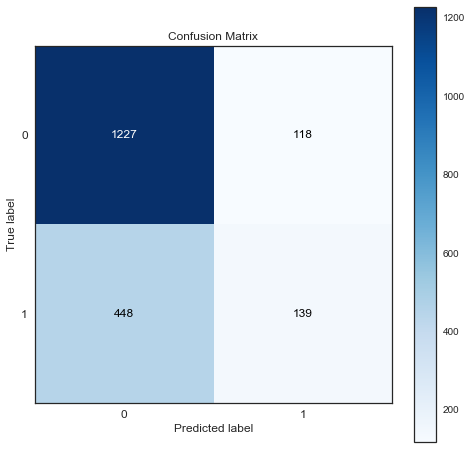

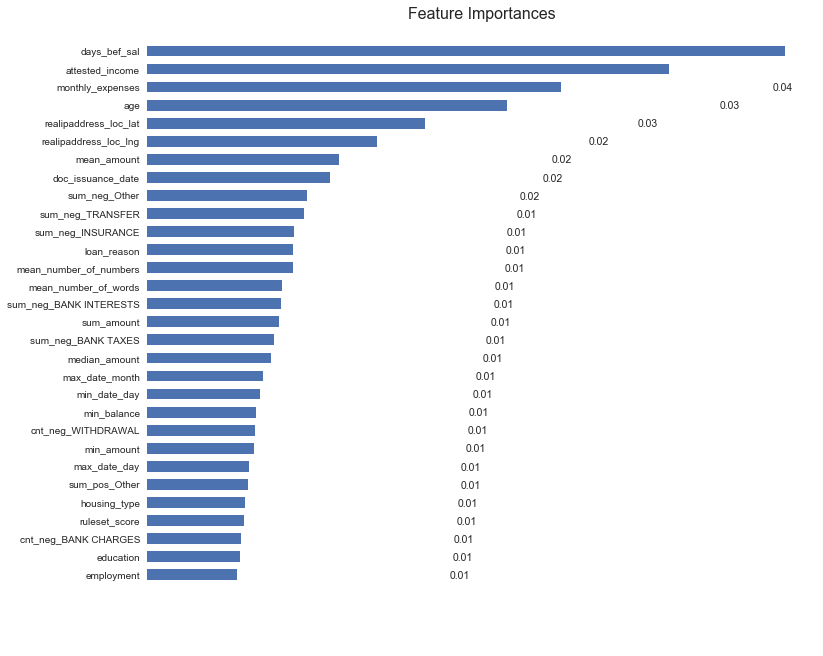

In [173]:
IDF.plot_score(clf, X_test, y_test)

# Model for Train

In [27]:
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 5,
                                 n_estimators = 100).fit(X, y)

In [28]:
joblib.dump(clf, 'appdata_algorithm_2018_04_11.pkl');

In [29]:
clf = joblib.load('appdata_algorithm_2018_04_11.pkl')

# ALL TABLES

In [62]:
appdata_exp = socdem['credit_id'].iloc[:,:1]
appdata_exp['Appdata_pred_proba'] = clf.predict_proba(X)[:,1]
appdata_exp['npl15'] = socdem['npl15']

In [98]:
vv = pd.read_excel('VV_DATA_2018_04_16.xlsx')
inst = pd.read_excel('Inst_DATA_16.xlsx')
df_end = pd.merge(appdata_exp, pd.merge(inst, vv, on ='credit_id', how='outer'), on ='credit_id', how='outer')

In [111]:
#df_end_to_copy = df_end.copy()
df_end = df_end_to_copy.copy()

In [113]:
df_end.VV_pred_proba.fillna(0.6, inplace=True)
df_end.Inst_pred_proba.fillna(0.34, inplace=True)

In [114]:
y_end = df_end.npl15
df_end.drop(['npl15'], axis = 1, inplace=True)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df_end, y_end, test_size=0.33, random_state=1)

In [116]:
train = X_train.copy()
test = X_test.copy()
X_train.drop('credit_id', inplace=True, axis=1)
X_test.drop('credit_id', inplace=True, axis=1)

In [ ]:
#df_end.drop('credit_id', inplace=True, axis=1)

# Early Scoring Test

In [117]:
#clf4 = CatBoostClassifier(verbose=False).fit(X_train, y_train)
clf5 = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 5,
                                 n_estimators = 100).fit(X_train, y_train)
clf6 = XGBClassifier(objective='binary:logistic', eval_metric="auc", nthreads=2).fit(X_train, y_train)

ROC_AUC:   0.8299031347560194
Gini:      0.6598062695120388
F1_score:  0.7429577464788732


Classification_report: 
              precision    recall  f1-score   support

          0       0.91      0.87      0.89      1396
          1       0.70      0.79      0.74       536

avg / total       0.86      0.85      0.85      1932





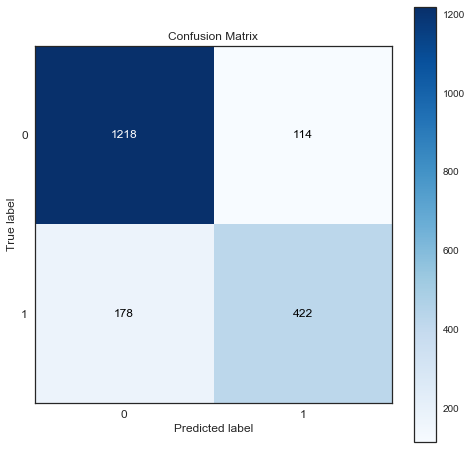

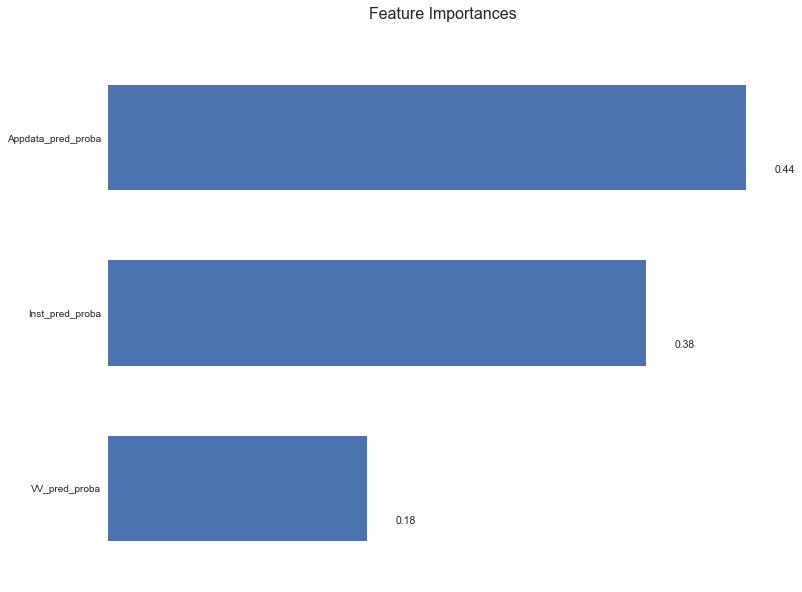

In [118]:
IDF.plot_score(clf6, X_test, y_test)

# Early Scoring Train

In [95]:
clf6 = XGBClassifier(objective='binary:logistic', eval_metric="auc", nthreads=2).fit(df_end, y_end)

In [96]:
joblib.dump(clf6, 'final_algorithm_2018_04_11.pkl');

# Export scores

In [ ]:
train = X_train.copy()
test = X_test.copy()
X_train.drop('credit_id', inplace=True, axis=1)
X_test.drop('credit_id', inplace=True, axis=1)

In [126]:
train['score'] = clf6.predict_proba(X_train)[:,1]
test['score'] = clf6.predict_proba(X_test)[:,1]

In [128]:
train = train[['credit_id', 'score']]
test = test[['credit_id', 'score']]

In [133]:
test.score = test.score.map(lambda x: round(float(x) * 1000))
train.score = train.score.map(lambda x: round(float(x) * 1000))

In [135]:
writer = pd.ExcelWriter('train_2018_04_11.xlsx')
train.to_excel(writer,'ES', index=False)
writer.save()
writer = pd.ExcelWriter('test_2018_04_11.xlsx')
test.to_excel(writer,'ES', index=False)
writer.save()

In [10]:
writer = pd.ExcelWriter('npl15.xlsx')
socdem.to_excel(writer,'ES', index=False)
writer.save()